In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os 
import imageio
import scipy.io as spio
import cv2
from numpy import sqrt, pi, exp, transpose, matmul
from numpy.linalg import det, inv
from scipy.stats import norm 
from scipy.stats import multivariate_normal
import time
import sys
from scipy.spatial import Delaunay
import matplotlib.image as mpimg
import dlib

%matplotlib inline
plt.style.use('default')

Step 0: Read images

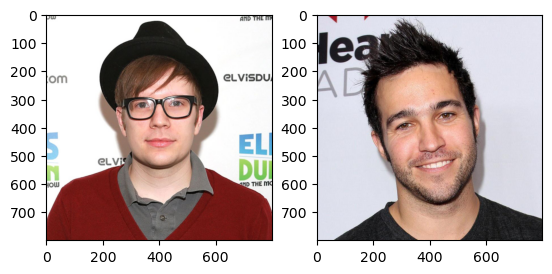

In [2]:
# the follow images are members of my favourite band Fall Out Boy
image1 = plt.imread("Orifaces\\patrick.jpg")
image2 = plt.imread("Orifaces\\pete.jpg")
plt.subplot(1, 2, 1)
plt.imshow(image1)
plt.subplot(1, 2, 2)
plt.imshow(image2)

step_num = 10

Step 1: Find some corresponding face landmarks between start and end images and display them

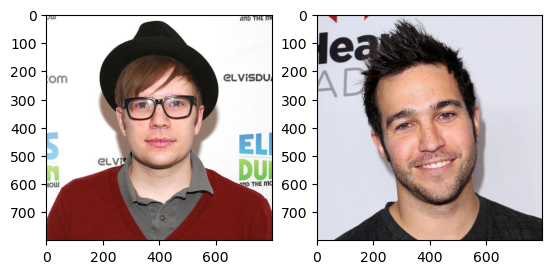

In [3]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

def get_landmarks(image):
    img_show = image.copy()
    landmarks = []
    detections = detector(image, 1)
    for k, d in enumerate(detections):
        shape = predictor(image, d)
        for i in range(0, 68):
            x = shape.part(i).x
            y = shape.part(i).y
            landmarks.append((x, y))
            # draw landmarks point on image
            cv2.circle(img_show, (x, y), 1, (0, 0, 255), -1)
    return landmarks, img_show

landmarks1, image1_with_landmarks = get_landmarks(image1)
landmarks2, image2_with_landmarks = get_landmarks(image2)

plt.subplot(1, 2, 1)
plt.imshow(image1_with_landmarks)
plt.subplot(1, 2, 2)
plt.imshow(image2_with_landmarks)

Step 2:  Create a triangulation and visualise it.

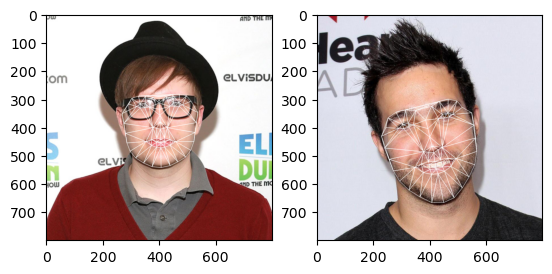

In [4]:
def draw_delaunay(img, points, triangles, color=(255, 255, 255)):
    # draw the triangles using given triangle indices
    img_show = img.copy()
    for tri in triangles:
        pt1 = (int(points[tri[0]][0]), int(points[tri[0]][1]))
        pt2 = (int(points[tri[1]][0]), int(points[tri[1]][1]))
        pt3 = (int(points[tri[2]][0]), int(points[tri[2]][1]))

        cv2.line(img_show, pt1, pt2, color, 1, cv2.LINE_AA, 0)
        cv2.line(img_show, pt2, pt3, color, 1, cv2.LINE_AA, 0)
        cv2.line(img_show, pt3, pt1, color, 1, cv2.LINE_AA, 0)
    return img_show

# Create Delaunay triangulation for the first image
delaunay_triangles1 = Delaunay(landmarks1)

# visualize
image1_show = draw_delaunay(image1, landmarks1, delaunay_triangles1.simplices)
image2_show = draw_delaunay(image2, landmarks2, delaunay_triangles1.simplices)

plt.subplot(1, 2, 1)
plt.imshow(image1_show)
plt.subplot(1, 2, 2)
plt.imshow(image2_show)
plt.show()

# get the triangles indexes
delaunay_triangles1 = delaunay_triangles1.simplices
# print(delaunay_triangles1) # indexes

Step3: Create the intermediate image coordinates

In [17]:
def interpolate_points(p1, p2, steps = step_num):
    # Create an array to hold the interpolated points
    interpolated_points = np.zeros((steps, p1.shape[0], 3, 2), dtype=np.float32)
    
    for t in range(p1.shape[0]):
        for v in range(3):  # Three vertices per triangle
            # Linear interpolation for x coordinate
            interpolated_points[:, t, v, 0] = np.linspace(p1[t, v, 0], p2[t, v, 0], num=steps)
            # Linear interpolation for y coordinate
            interpolated_points[:, t, v, 1] = np.linspace(p1[t, v, 1], p2[t, v, 1], num=steps)
            
    return interpolated_points

# Get the actual triangle vertices for each image
triangles1 = np.array([[landmarks1[vertex] for vertex in triangle] for triangle in delaunay_triangles1])
triangles2 = np.array([[landmarks2[vertex] for vertex in triangle] for triangle in delaunay_triangles1])

# Perform interpolation
interpolated_triangles = interpolate_points(triangles1, triangles2)
print(interpolated_triangles.shape) # 返回的是坐标值

(10, 116, 3, 2)


Step4: For every pair of corresponding triangles, take the 3 pairs of corresponding vertices and estimate an Affine warp.

In [29]:
def perturb_points(points, perturbation_scale=1e-10):
    # 添加一个小的随机扰动到点来破坏共线性
    return points + np.random.uniform(-perturbation_scale, perturbation_scale, points.shape)

#计算仿射变换矩阵
def compute_affine_transform(begin,end):
    max_attempts = 10
    for attempt in range(max_attempts):
        A = np.array([
            [begin[0][0], begin[0][1], 1, 0, 0, 0],
            [0, 0, 0, begin[0][0], begin[0][1], 1],
            [begin[1][0], begin[1][1], 1, 0, 0, 0],
            [0, 0, 0, begin[1][0], begin[1][1], 1],
            [begin[2][0], begin[2][1], 1, 0, 0, 0],
            [0, 0, 0, begin[2][0], begin[2][1], 1]
        ])
        B = np.array([end[0][0], end[0][1], end[1][0], end[1][1], end[2][0], end[2][1]])

        if np.linalg.det(A) != 0:
            # 如果A不是奇异的，计算逆矩阵并退出循环
            # Solve the linear equation A * X = B for X
            X = np.linalg.solve(A, B)
            X = X.reshape(2, 3)
            return X
        else:
            # 如果P是奇异的，添加一个小的扰动到begin点
            begin = perturb_points(np.array(begin))
    # 如果尝试了max_attempts次仍未成功，则放弃并返回None或抛出异常
    raise ValueError("Unable to compute an affine transform due to collinear points after several attempts.")



Step5: Map all corresponding points between the triangles.

In [25]:
def is_point_in_triangle(pt, tri):
    """检查点是否在三角形内"""
    def sign(p1, p2, p3):
        return (p1[0] - p3[0]) * (p2[1] - p3[1]) - (p2[0] - p3[0]) * (p1[1] - p3[1])
    b1 = sign(pt, tri[0], tri[1]) < 0.0
    b2 = sign(pt, tri[1], tri[2]) < 0.0
    b3 = sign(pt, tri[2], tri[0]) < 0.0
    return ((b1 == b2) and (b2 == b3))

#获取三角形区域内所有像素点
def get_triangle_pixels(triangle):
    pixels = []
    # 计算源三角形的边界矩形
    min_x = int(min([v[0] for v in triangle]))
    max_x = int(max([v[0] for v in triangle]))
    min_y = int(min([v[1] for v in triangle]))
    max_y = int(max([v[1] for v in triangle]))
    #生成边界内的所有点
    for x in range(min_x, max_x + 1):
        for y in range(min_y, max_y + 1):
            #它用于检测一个点是否在一个多边形内部、外部或者正好在多边形的边界上
            #最后一个参数measureDist是一个布尔值，指示是否计算并返回点到多边形最近边的距离：
            if is_point_in_triangle((x, y), triangle):
                pixels.append((x, y))
    return pixels


In [9]:
# 颜色应该是想找img1上的xy的坐标对应的颜色，再找img2上的xy坐标对应的颜色，在用weight插值
def bilinear_interpolate(img, y, x):
    h, w, c = img.shape
    #（x0,y0)是左上角像素点
    x0, y0 = int(x), int(y)
    #（x1,y1）是右下角像素点
    x1, y1 = min(x0 + 1, w - 1), min(y0 + 1, h - 1)
    #权重是根据目标点与邻近四个像素坐标的相对距离来计算的。
    wa = (x1 - x) * (y1 - y)
    wb = (x1 - x) * (y - y0)
    wc = (x - x0) * (y1 - y)
    wd = (x - x0) * (y - y0)
    #使用加权平均的方法计算插值
    return wa * img[y0, x0] + wb * img[y1, x0] + wc * img[y0, x1] + wd * img[y1, x1]

#应用逆仿射变换矩阵 将其从当前的坐标系映射回原始图像的坐标系中
def apply_inverse_affine_transform(pixels,affine_transform):
    affine_transform=np.array(affine_transform)
    transformed_pixels = []
    affine_augmented = np.vstack((affine_transform, np.array([0, 0, 1])[np.newaxis, :]))
    affine_inverse = np.linalg.inv(affine_augmented)[:2, :]
    for pixel in pixels:
        #创建了一个齐次坐标表示的像素位置，加一个1将仿射变换包含平移在内的操作统一成矩阵乘法
        pixel_homogeneous = np.array([pixel[0], pixel[1], 1])
        transformed_pixel = affine_inverse.dot(pixel_homogeneous)
        transformed_pixels.append(transformed_pixel)
    return transformed_pixels

#应用仿射变换矩阵 将其从当前的坐标系映射image2的坐标系中
def apply_affine_transform(pixels, affine_transform):
    # 将 affine_transform 转换成一个 NumPy 数组，以便进行矩阵运算
    affine_transform = np.array(affine_transform)
    # 创建一个变换后的像素列表
    transformed_pixels = []
    # 对每个像素点进行仿射变换
    for pixel in pixels:
        # 创建齐次坐标表示的像素位置
        pixel_homogeneous = np.array([pixel[0], pixel[1], 1])
        # 应用仿射变换矩阵
        transformed_pixel = affine_transform.dot(pixel_homogeneous)
        # 将变换后的点添加到列表
        transformed_pixels.append(transformed_pixel[:2])  # 只取 x' 和 y'，忽略齐次坐标的最后一个元素
    return transformed_pixels



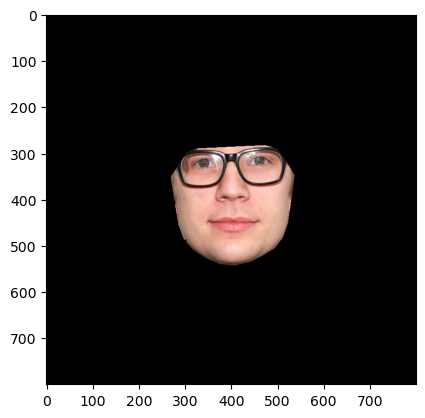

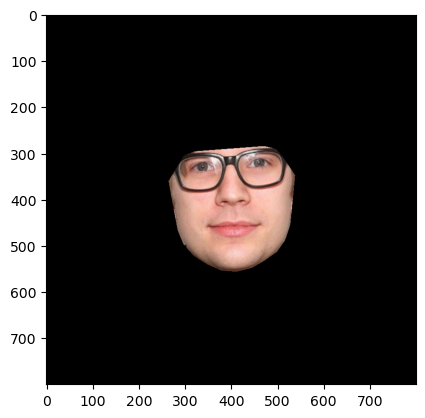

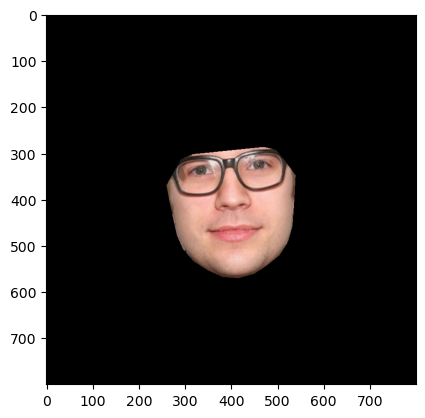

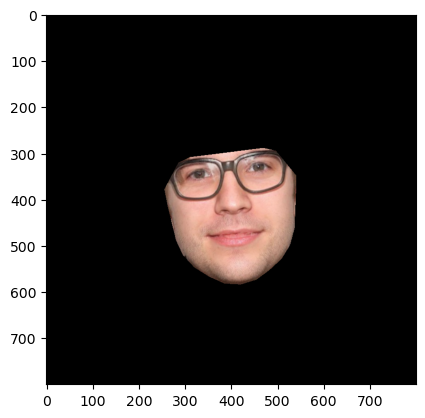

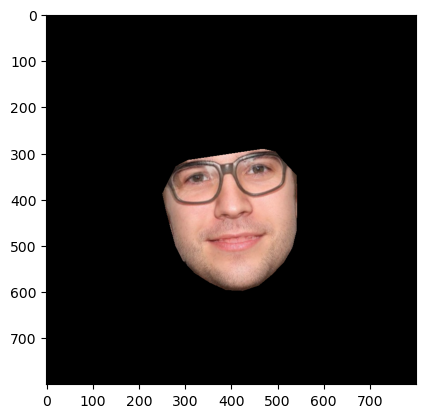

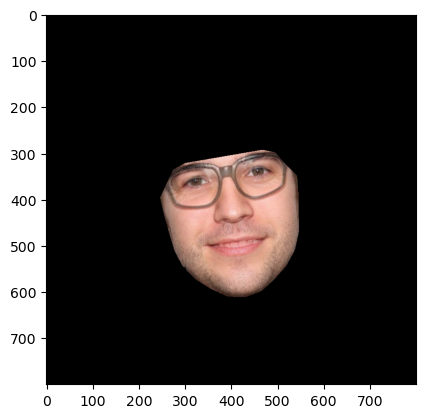

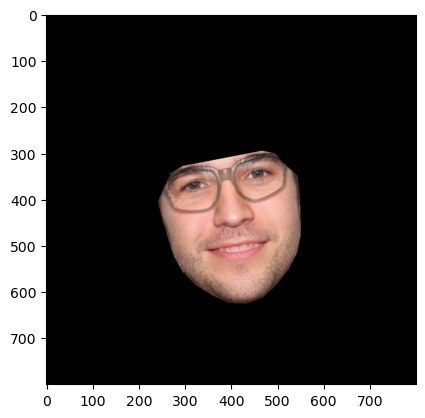

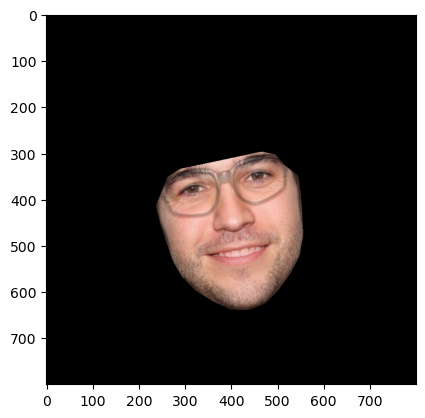

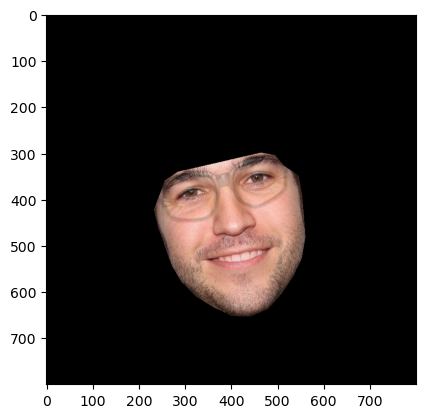

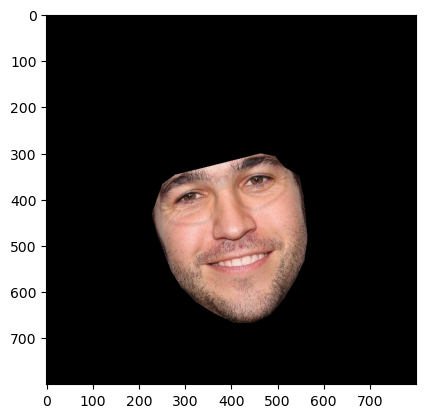

In [30]:
intermediate_images=[]
intermediate_images.append(image1)
save_dir = "result_images" 

for step in range(step_num):
    # 创建一个空白的中间图像
    intermediate_image = np.zeros(image1.shape, dtype=image1.dtype)
    alpha = step * 1. / step_num

    # 遍历每一个三角形的索引
    for i in range(len(delaunay_triangles1)):
        tri_intermediate = interpolated_triangles[step][i]
        # print(tri_intermediate)
        
        #计算仿射变换
        # 拿image1的点
        affine_transform = compute_affine_transform(triangles1[i], tri_intermediate)
        # 提取三角形区域所有像素点
        triangle_pixels = get_triangle_pixels(tri_intermediate)
        # 应用逆仿射变换来找到源图像中对应的像素位置
        src_pixels = apply_inverse_affine_transform(triangle_pixels,affine_transform)
        
        # 拿image2的点
        affine_transform2 = compute_affine_transform(tri_intermediate, triangles2[i])
        dst_pixels = apply_affine_transform(triangle_pixels,affine_transform2)
        
        #print(src_pixels.shape)
        # 对于源图像中的每个像素位置，使用双线性插值找到像素值，并将其映射到中间图像
        for i, pixel in enumerate(triangle_pixels):
            src_x, src_y = src_pixels[i][0], src_pixels[i][1]
            dst_x, dst_y = dst_pixels[i][0], dst_pixels[i][1]
            # 双线性插值
            if 0 <= src_x < image1.shape[1]-1 and 0 <= src_y < image1.shape[0]-1:
                pixel_value = bilinear_interpolate(image1, src_y, src_x)
                pixel_value2 = bilinear_interpolate(image2, dst_y, dst_x)
                pixel_value = (1 - alpha) * pixel_value + alpha * pixel_value2
                intermediate_image[(int)(pixel[1]), (int)(pixel[0])] = pixel_value
    
    # mask = (intermediate_image == 0)
    # intermediate_image[mask] = (1 - alpha) * img1[mask] + alpha * img2[mask]
    plt.imshow(intermediate_image)
    plt.show()
    intermediate_images.append(intermediate_image)

intermediate_images.append(image2)
plt.show()




In [39]:
# generate video
output_path = 'output/video.mp4'

with imageio.get_writer(output_path, mode='I') as writer:
  for k in range(11):
    writer.append_data(intermediate_images[k])
#end_solution

Video(output_path)


NameError: name 'Video' is not defined

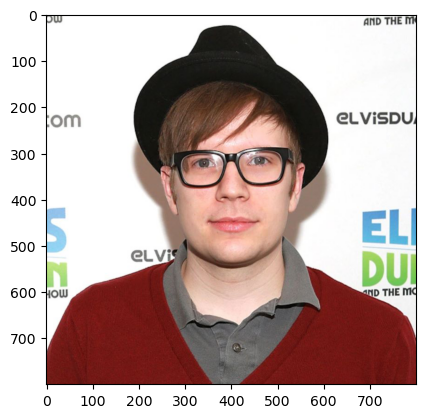

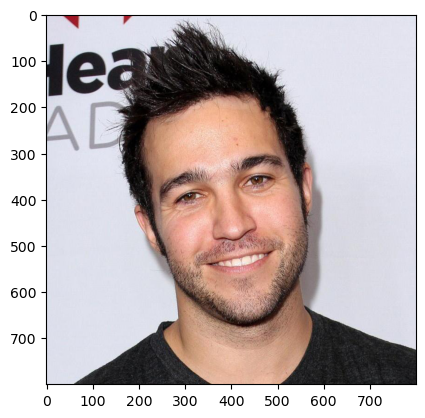

(10, 116, 3, 2)


NameError: name 'estimate_affine_transform' is not defined

In [12]:
plt.imshow(image1)
plt.show()
plt.imshow(image2)
plt.show()

def warp_triangle(image, src_triangle, dst_triangle):
    # 创建一个空的变形图像
    warped_image = np.zeros_like(image)
    # 获取源和目标三角形的仿射变换矩阵
    affine_transform = estimate_affine_transform(src_triangle, dst_triangle)
    # 映射源三角形到目标三角形的点
    points_mapping = map_points(src_triangle, dst_triangle, affine_transform)
    # 对每个点应用映射
    for src, dst in points_mapping:
        x, y = int(src[0]), int(src[1])
        x_dst, y_dst = int(dst[0]), int(dst[1])
        if 0 <= x_dst < image.shape[1] and 0 <= y_dst < image.shape[0]:
            warped_image[y_dst, x_dst] = bilinear_interpolate(image, y, x)
    return warped_image

#双线性插值
def bilinear_interpolate(img, y, x):
    #（x0,y0)是左上角像素点
    x0 = int(x)
    y0 = int(y)
    #（x1,y1）是右下角像素点
    x1 = x0 + 1
    y1 = y0 + 1
    #左上像素值Ia，左下像素值Ib，右上Ic
    Ia = img[y0, x0]
    Ib = img[y1, x0]
    Ic = img[y0, x1]
    Id = img[y1, x1]
    #权重是根据目标点与邻近四个像素坐标的相对距离来计算的。
    wa = (x1 - x) * (y1 - y)
    wb = (x1 - x) * (y - y0)
    wc = (x - x0) * (y1 - y)
    wd = (x - x0) * (y - y0)
    #使用加权平均的方法计算插值
    return wa * Ia + wb * Ib + wc * Ic + wd * Id

def blend_images(image1, image2, weight):
    # 线性混合两个图像
    return (1 - weight) * image1 + weight * image2

height, width, c = image1.shape
stepCur = 0

print(interpolated_triangles.shape)

# 假设 step 已经定义为需要的步数
num_steps = 10

# 对每个权重值进行操作
for w in np.linspace(0, 1, num = num_steps):
    # 当前步骤的索引
    stepCur = int(round(w * (num_steps)))
    
    # 变形 S_image 和 E_image
    warped_S = np.zeros_like(image1, dtype=np.float32)
    warped_E = np.zeros_like(image2, dtype=np.float32)
    
    # 获取当前步骤的插值三角形
    interpolated_tri = interpolated_triangles[stepCur]

    # 对每个三角形进行变形和融合
    for i, (src_tri, dst_tri) in enumerate(zip(triangles1, triangles2)):
        # 变形 S_image 和 E_image
        warped_S += warp_triangle(image1, interpolated_tri[i], src_tri)
        warped_E += warp_triangle(image2, interpolated_tri[i], dst_tri)
    
    warped_S = np.clip(warped_S, 0, 255)
    warped_E = np.clip(warped_E, 0, 255)
    # process the pixels not included in the triangles
    # print(warped_S)
    # mask = (warped_S == 0)
    # warped_S[mask] = image1[mask]
    # mask = (warped_E == 0)
    # warped_E[mask] = image2[mask]
    
    # 混合变形后的图像
    blended_image = blend_images(warped_S, warped_E, w)
    # print(blended_image)
    # 确保像素值在0到255之间
    blended_image = np.clip(blended_image, 0, 255).astype(np.uint8)

    plt.imshow(blended_image)
    plt.show()
    # 可以在这里使用 cv2.imwrite 来保存每一步的融合图像

# # 假设 step 已经定义为需要的步数
# num_steps = 10

# # 对每个权重值进行操作
# for w in np.linspace(0, 1, num = num_steps - 1):
#     # 当前步骤的索引
#     stepCur = int(round(w * (num_steps - 1)))
#     print(stepCur)
    
#     # 变形 S_image 和 E_image
#     warped_S = np.zeros_like(image1, dtype=np.float32)
#     warped_E = np.zeros_like(image2, dtype=np.float32)
    
#     # 获取当前步骤的插值三角形
#     last_tri = interpolated_triangles[stepCur]
#     interpolated_tri = interpolated_triangles[stepCur - 1]

#     # 对每个三角形进行变形和融合
#     for i, (src_tri, dst_tri) in enumerate(zip(triangles1, triangles2)):
#         # 变形 S_image 和 E_image
#         #print(last_tri[i])
#         #print(interpolated_tri[i])
#         warped_S += warp_triangle(image1, src_tri, last_tri[i])
    
#     last_tri = interpolated_tri
#     warped_S = np.clip(warped_S, 0, 255)
#     warped_E = np.clip(warped_E, 0, 255)
    
#     # 混合变形后的图像
#     # blended_image = blend_images(warped_S, warped_E, w)
#     blended_image = warped_S
#     #print(blended_image)
#     # 确保像素值在0到255之间
#     blended_image = np.clip(blended_image, 0, 255).astype(np.uint8)

#     plt.imshow(blended_image)
#     plt.show()
#     # 可以在这里使用 cv2.imwrite 来保存每一步的融合图像

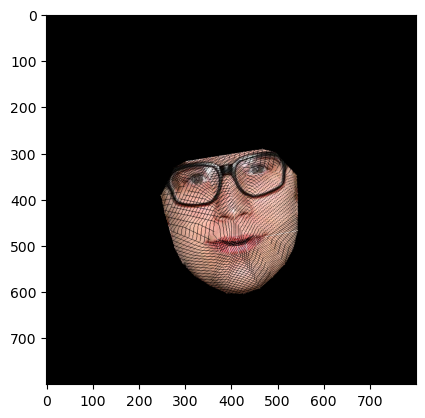

In [ ]:
def morph_triangle(img1, img2, tri1, tri2, tri_intermediate, alpha):
    # 计算仿射变换
    affine_transform = estimate_affine_transform(tri1, tri_intermediate)
    # 提取三角形区域所有像素点
    triangle_pixels = map_points(tri1, tri_intermediate, affine_transform)
    # 创建一个空白的中间图像
    intermediate_img = np.zeros(img1.shape, dtype=img1.dtype)

    for src, dst in triangle_pixels:
        x, y = src # 在img1上的位置
        x_dst, y_dst = dst # 在当前帧图像上的位置
        # 双线性插值
        if 0 <= x < img1.shape[1] and 0 <= y < img1.shape[0]:
            pixel_value = bilinear_interpolate(img1, y, x)
            intermediate_img[int(y_dst), int(x_dst)] = pixel_value

    # 混合图像
    # blended_img = blend_images(intermediate_img, img2, alpha) / 255
    blended_img = intermediate_img.astype(np.float32)
    return blended_img

def face_morph(img1, img2, points1, points2, triangle_indices, alpha):
    # Ensure morphed_img is a float array to hold intermediate results
    morphed_img = np.zeros(img1.shape, dtype=np.float32)  # Change dtype to float32

    for i, tri_indices in enumerate(triangle_indices):
        tri1 = [points1[idx] for idx in tri_indices]
        tri2 = [points2[idx] for idx in tri_indices]
        tri_intermediate = interpolate_points(np.array(tri1), np.array(tri2), alpha)

        # Ensure that morph_triangle returns a float32 array
        # And add it to the existing float32 morphed_img array
        morphed_img += morph_triangle(img1, img2, tri1, tri2, tri_intermediate, alpha).astype(np.float32)
    
    # After all processing, clip to [0, 255] and convert to uint8
    morphed_img = np.clip(morphed_img, 0, 255).astype(np.uint8)
    return morphed_img


# 示例使用
alpha = 0.5  # 混合比例
morphed_image = face_morph(image1, image2, landmarks1, landmarks2, delaunay_triangles1, alpha)

plt.imshow(morphed_image)